# TF-MoDISco on the Nanog GkmExplain Scores, but without MEME init

Like the TF MoDISco Nanog notebook, but lacking the MEME cluster initialization step.

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
print (sys.version)
import os

3.8.3 (default, Jul  2 2020, 11:26:31) 
[Clang 10.0.0 ]


## Grab the input data

In [3]:
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/positives_test.fa.gz -O positives_test.fa.gz
!gunzip -f positives_test.fa.gz 
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_positives_hypimpscores.txt.gz -O gkmexplain_positives_hypimpscores.txt.gz
!gunzip -f gkmexplain_positives_hypimpscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_dnshuff_hypimpscores.txt.gz -O gkmexplain_dnshuff_hypimpscores.txt.gz
!gunzip -f gkmexplain_dnshuff_hypimpscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/dnshuff_seqs.fa.gz -O dnshuff_seqs.fa.gz
!gunzip -f dnshuff_seqs.fa.gz

--2021-03-07 15:44:06--  https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/positives_test.fa.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75038 (73K) [application/octet-stream]
Saving to: ‘positives_test.fa.gz’

positives_test.fa.g 100%[===================>]  73.28K  --.-KB/s    in 0.08s   

2021-03-07 15:44:07 (916 KB/s) - ‘positives_test.fa.gz’ saved [75038/75038]

--2021-03-07 15:44:07--  https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_positives_hypimpscores.txt.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|

### Read in the one-hot encoded sequences and scores

In [4]:
import numpy as np

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1


def read_in_seqs_and_scores(fa_file, hypimpscores_file):
    seqs = [x.rstrip() for (i,x) in enumerate(open(fa_file)) if i%2==1]
    #filter out any sequences that contain 'N's
    onehot_data = [np.array(one_hot_encode_along_channel_axis(x))
                   for x in seqs if ('N' not in x)]
    #read in the hypothetical importance scores,
    # filter out any sequences that contain 'N's
    unnorm_hyp_impscores = [w[0] for w in zip([
        np.array( [[float(z) for z in y.split(",")]
            for y in x.rstrip().split("\t")[2].split(";")])
        for x in open(hypimpscores_file)],seqs)
        if 'N' not in w[1]]
    #in the original GkmExplain paper, a normalization of the
    # importance scores and hypothetical importance scores was
    # proposed, as this was empirically observed to improve
    # the signal-to-noise ratio. Here, I will do a
    # similar-in-spirit normalization that also appears to
    # improve the signal-to-noise ratio, but which is more
    # intuitive and better-motivated than the normalization
    # from the gkmexplain paper (the reason I didn't propose it
    # in that paper is simply that I hadn't considered it).
    #The normalization consists of subtracting the mean
    # hypothetical importance across ACGT at each position such
    # that the sum of the hypothetical importance at each position
    # is 0. The intuition is that this highlights the impact of
    # each base on the output **relative to the other bases that
    # could have been present**. The normalized actual importance
    # is simply the normalized hypothetical importance multiplied
    # by the one-hot encoding.
    hyp_impscores = [x - np.mean(x, axis=-1)[:,None] for x in unnorm_hyp_impscores]
    impscores = [x*y for x,y in zip(hyp_impscores, onehot_data)]
    
    return onehot_data, hyp_impscores, impscores
    

onehot_data, hyp_impscores, impscores = read_in_seqs_and_scores(
    fa_file="positives_test.fa",
    hypimpscores_file="gkmexplain_positives_hypimpscores.txt")
print("Num onehot sequences:",len(onehot_data))

_, _, nulldist_impscores = read_in_seqs_and_scores(
    fa_file="dnshuff_seqs.fa",
    hypimpscores_file="gkmexplain_dnshuff_hypimpscores.txt")
nulldist_perposimp = np.sum(nulldist_impscores, axis=-1)

Num onehot sequences: 960


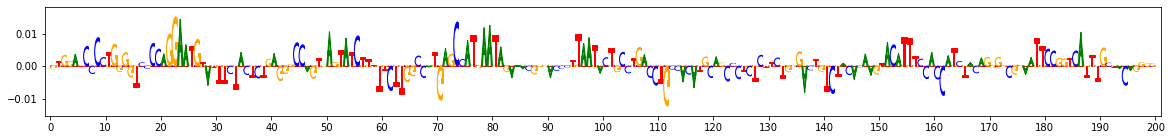

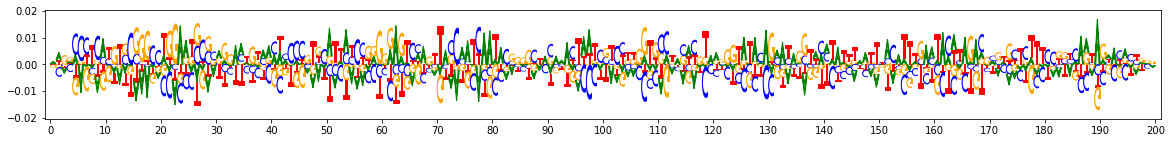

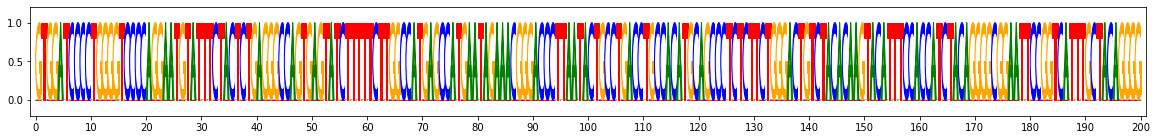

In [5]:
from matplotlib import pyplot as plt
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(hyp_impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=10)


## Run TF-MoDISco

TF-MoDISco is using the TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term
MEMORY 0.348700672
On task task0
Computing windowed sums on original
Generating null dist
Computing threshold


TF-MoDISco is using the TensorFlow backend.


For increasing = True , the minimum IR precision was 0.28762191141268867 occurring at 1.1961500000490233e-06 implying a frac_neg of 0.40374895862260485
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.4829015187051677 occurring at -5.614999999965353e-07 implying a frac_neg of 0.9338676019623297
To be conservative, adjusted frac neg is 0.95
Thresholds from null dist were -0.21752344639999993  and  0.15626441020500015 with frac passing 0.07338541666666666
Final raw thresholds are -0.21752344639999993  and  0.15626441020500015
Final transformed thresholds are -0.9723900462962963  and  0.9213773148148148


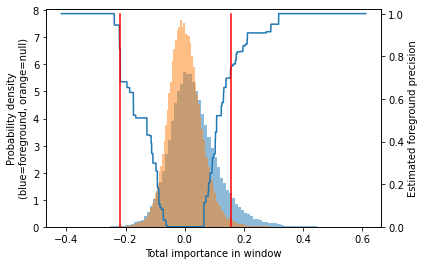

Got 923 coords
After resolving overlaps, got 923 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9212773148148148
MEMORY 0.419241984
923 identified in total
1 activity patterns with support >= 100 out of 2 possible patterns
Metacluster sizes:  [903]
Idx to activities:  {0: '1'}
MEMORY 0.419282944
On metacluster 0
Metacluster size 903
Relevant tasks:  ('task0',)
Relevant signs:  (1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 903
(Round 1) Computing coarse affmat
MEMORY 0.420057088
Beginning embedding computation
MEMORY 0.420057088


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 336 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 896 out of 903 | elapsed:   17.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 903 out of 903 | elapsed:   17.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done 903 out of 903 | elapsed:   16.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 903 out of 903 | elapsed:    2.0s finished


Constructing csr matrix...
csr matrix made in 0.19544410705566406 s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 903 out of 903 | elapsed:    2.0s finished


Constructing csr matrix...
csr matrix made in 0.20043611526489258 s
Finished embedding computation in 38.29 s
MEMORY 0.766906368
Starting affinity matrix computations
MEMORY 0.766906368
Batching in slices of size 903


100%|██████████| 1/1 [00:02<00:00,  2.07s/it]

Finished affinity matrix computations in 2.08 s
MEMORY 0.780075008
(Round 1) Computed coarse affmat
MEMORY 0.780075008
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 0.780075008


Launching nearest neighbors affmat calculation job
MEMORY 0.783118336
Parallel runs completed
MEMORY 0.814927872
Job completed in: 15.25 s
MEMORY 0.814927872
Launching nearest neighbors affmat calculation job
MEMORY 0.814927872
Parallel runs completed
MEMORY 0.823750656
Job completed in: 15.31 s
MEMORY 0.823750656
(Round 1) Computed affinity matrix on nearest neighbors in 30.82 s
MEMORY 0.833032192
Filtered down to 898 of 903
(Round 1) Retained 898 rows out of 903 after filtering
MEMORY 0.833277952
(Round 1) Computing density adapted affmat
MEMORY 0.833282048
[t-SNE] Computed conditional probabilities for sample 898 / 898
[t-SNE] Mean sigma: 0.235699
(Round 1) Computing clustering
MEMORY 0.837361664
Beginning preprocessing + Leiden


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.9s


Quality: 0.652450752000259
Quality: 0.6525780317777266
Got 11 clusters after round 1
Counts:
{2: 125, 3: 122, 7: 8, 0: 249, 1: 227, 9: 6, 6: 26, 4: 89, 10: 6, 8: 7, 5: 33}
MEMORY 0.837480448
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.837480448
Aggregating for cluster 0 with 249 seqlets
MEMORY 0.837480448


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    8.0s finished


Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 19 seqlets that went over sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 229
Skipped 18 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 1 with 227 seqlets
MEMORY 0.837586944
Skipped 3 seqlets that went over the sequence edge during flank expansion
Skipped 3 seqlets that went over the sequence edge during flank expansion
Skipped 21 seqlets that went over sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 200
Skipped 21 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 2 with 125 seqlets
MEMORY 0.837677056
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 14 seqlets that went over sequence edge during fla

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 721 out of 721 | elapsed:    9.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 721 out of 721 | elapsed:    9.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 721 out of 721 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Constructing csr matrix...
csr matrix made in 0.1558840274810791 s


[Parallel(n_jobs=1)]: Done 721 out of 721 | elapsed:    1.6s finished


Constructing csr matrix...
csr matrix made in 0.15420866012573242 s
Finished embedding computation in 22.57 s
MEMORY 0.843862016
Starting affinity matrix computations
MEMORY 0.843862016
Batching in slices of size 721


100%|██████████| 1/1 [00:01<00:00,  1.98s/it]

Finished affinity matrix computations in 1.98 s
MEMORY 0.846790656
(Round 2) Computed coarse affmat
MEMORY 0.846790656
(Round 2) Computing affinity matrix on nearest neighbors
MEMORY 0.846790656


Launching nearest neighbors affmat calculation job
MEMORY 0.846802944
Parallel runs completed
MEMORY 0.88440832
Job completed in: 25.03 s
MEMORY 0.88440832
Launching nearest neighbors affmat calculation job
MEMORY 0.88440832
Parallel runs completed
MEMORY 0.886591488
Job completed in: 24.74 s
MEMORY 0.886591488
(Round 2) Computed affinity matrix on nearest neighbors in 50.01 s
MEMORY 0.88885248
Not applying filtering for rounds above first round
MEMORY 0.88885248
(Round 2) Computing density adapted affmat
MEMORY 0.888856576
[t-SNE] Computed conditional probabilities for sample 721 / 721
[t-SNE] Mean sigma: 0.239763
(Round 2) Computing clustering
MEMORY 0.88938496
Beginning preprocessing + Leiden


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.6s


Quality: 0.6021282399716362
Quality: 0.602928725287126
Quality: 0.6030455877580038
Quality: 0.6031360994261559
Quality: 0.6037652171204421
Got 9 clusters after round 2
Counts:
{0: 206, 5: 53, 1: 186, 4: 56, 8: 2, 2: 131, 7: 7, 3: 68, 6: 12}
MEMORY 0.88938496
(Round 2) Aggregating seqlets in each cluster
MEMORY 0.88938496
Aggregating for cluster 0 with 206 seqlets
MEMORY 0.88938496


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    7.7s finished


Trimming eliminated 0 seqlets out of 206
Skipped 14 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 1 with 186 seqlets
MEMORY 0.889606144
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 2 seqlets that went over sequence edge during flank expansion
Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 182
Skipped 24 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 2 with 131 seqlets
MEMORY 0.88967168
Skipped 1 seqlets that went over sequence edge during flank expansion
Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 129
Skipped 11 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 3 with 68 seqlets
MEMORY 0.88969216
Skipped 1 seqlets that went over the sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 67
Skipped 1 seqlets that went over the sequence edge during flank expansion
Aggregating

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 192 out of 192 | elapsed:    0.1s finished


Beginning preprocessing + Leiden


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s


Quality: 0.1778057164358179
Quality: 0.1804250021716665
Quality: 0.18045931169509719
Quality: 0.18092804071297003
Quality: 0.18123932070047663
Quality: 0.18190981235578416
Got subclusters: Counter({0: 43, 1: 42, 2: 34, 3: 29, 5: 22, 4: 22})
On merging iteration 1


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.6s finished


Numbers for each pattern pre-subsample: [43, 42, 34, 29, 22, 22]
Numbers after subsampling: [43, 42, 34, 29, 22, 22]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.16117238998413086 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.1512291431427002 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.14705109596252441 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.12967896461486816 s
Computing sims for pattern 4
Computed sims for pattern 4 in 0.1094510555267334 s
Computing sims for pattern 5
Computed sims for pattern 5 in 0.11186671257019043 s
Cluster sizes
[43 42 34 29 22 22]
Cross-contamination matrix:
[[1.   0.81 0.69 0.86 0.98 0.73]
 [0.86 1.   0.67 0.87 1.   0.76]
 [0.91 0.89 1.   0.93 1.   0.79]
 [0.82 0.77 0.65 1.   0.9  0.69]
 [0.71 0.62 0.49 0.66 1.   0.53]
 [0.87 0.88 0.71 0.89 0.97 1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.95 0.92 0.95 0.95 0.94]
 [0.95 1.   0.92 0.94 0.95 0.93]
 [0.92 0.92 1.   0.93 0.92 0.88]
 [

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 158 out of 158 | elapsed:    0.1s finished


Beginning preprocessing + Leiden


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s


Quality: 0.20511586655064198
Quality: 0.2067671294960168
Quality: 0.20994110258727935
Quality: 0.21025319423050154
Quality: 0.21064364451674902
Quality: 0.21101788308460226
Got subclusters: Counter({0: 46, 1: 44, 2: 29, 3: 24, 4: 15})
On merging iteration 1


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.2s finished


Numbers for each pattern pre-subsample: [46, 44, 29, 24, 15]
Numbers after subsampling: [46, 44, 29, 24, 15]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.1407170295715332 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.1316831111907959 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.09673500061035156 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.0845189094543457 s
Computing sims for pattern 4
Computed sims for pattern 4 in 0.07591390609741211 s
Cluster sizes
[46 44 29 24 15]
Cross-contamination matrix:
[[1.   0.44 0.42 0.7  0.57]
 [0.96 1.   0.8  0.91 0.93]
 [0.9  0.75 1.   0.79 0.82]
 [0.8  0.47 0.42 1.   0.63]
 [0.77 0.63 0.57 0.75 1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.87 0.83 0.9  0.84]
 [0.87 1.   0.86 0.87 0.88]
 [0.83 0.86 1.   0.81 0.81]
 [0.9  0.87 0.81 1.   0.85]
 [0.84 0.88 0.81 0.85 1.  ]]
Collapsing 0 & 3 with crosscontam 0.7035423687022273 and sim 0.9049062731472548
Collapsing 1 & 4 with crossconta

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 102 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 118 out of 118 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s


Quality: 0.18819164336884656
Got subclusters: Counter({0: 43, 1: 41, 2: 23, 3: 11})
On merging iteration 1


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.8s finished


Numbers for each pattern pre-subsample: [43, 41, 23, 11]
Numbers after subsampling: [43, 41, 23, 11]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.10600590705871582 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.09844398498535156 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.07830381393432617 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.052866220474243164 s
Cluster sizes
[43 41 23 11]
Cross-contamination matrix:
[[1.   0.73 0.6  0.73]
 [0.78 1.   0.7  0.73]
 [0.73 0.77 1.   0.64]
 [0.7  0.67 0.54 1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.85 0.8  0.81]
 [0.85 1.   0.81 0.78]
 [0.8  0.81 1.   0.7 ]
 [0.81 0.78 0.7  1.  ]]
Inspecting pattern 3 for spurious merging
[t-SNE] Computed conditional probabilities for sample 66 / 66
[t-SNE] Mean sigma: 0.661975
Beginning preprocessing + Leiden


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  66 out of  66 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s


Quality: 0.12542745196991448
Got subclusters: Counter({0: 29, 1: 22, 2: 15})
On merging iteration 1
Numbers for each pattern pre-subsample: [29, 22, 15]
Numbers after subsampling: [29, 22, 15]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.0562748908996582 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.04159832000732422 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.035109758377075195 s
Cluster sizes
[29 22 15]
Cross-contamination matrix:
[[1.   0.55 0.54]
 [0.51 1.   0.5 ]
 [0.78 0.76 1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.69 0.79]
 [0.69 1.   0.72]
 [0.79 0.72 1.  ]]
Inspecting pattern 4 for spurious merging
Inspecting pattern 5 for spurious merging
Inspecting pattern 6 for spurious merging
Inspecting pattern 7 for spurious merging
Inspecting pattern 8 for spurious merging
Merging on 14 clusters
MEMORY 0.890384384
On merging iteration 1


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.6s finished


Numbers for each pattern pre-subsample: [181, 158, 43, 41, 23, 11, 29, 22, 15, 48, 49, 12, 5, 2]
Numbers after subsampling: [181, 158, 43, 41, 23, 11, 29, 22, 15, 48, 49, 12, 5, 2]
Computing sims for pattern 0
Computed sims for pattern 0 in 2.357642412185669 s
Computing sims for pattern 1
Computed sims for pattern 1 in 1.6551179885864258 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.4305100440979004 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.42674708366394043 s
Computing sims for pattern 4
Computed sims for pattern 4 in 0.32154107093811035 s
Computing sims for pattern 5
Computed sims for pattern 5 in 0.2134568691253662 s
Computing sims for pattern 6
Computed sims for pattern 6 in 0.39563798904418945 s
Computing sims for pattern 7
Computed sims for pattern 7 in 0.35689330101013184 s
Computing sims for pattern 8
Computed sims for pattern 8 in 0.3006250858306885 s
Computing sims for pattern 9
Computed sims for pattern 9 in 0.5361120700836182 s
Comput

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 181 out of 181 | elapsed:    0.2s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


[t-SNE] Computed conditional probabilities for sample 181 / 181
[t-SNE] Mean sigma: 0.337255
[t-SNE] Computed conditional probabilities in 0.010s
[t-SNE] Iteration 50: error = 66.4027557, gradient norm = 0.3863434 (50 iterations in 0.041s)
[t-SNE] Iteration 100: error = 63.7479324, gradient norm = 0.4634853 (50 iterations in 0.034s)
[t-SNE] Iteration 150: error = 61.7870636, gradient norm = 0.4860046 (50 iterations in 0.032s)
[t-SNE] Iteration 200: error = 65.1613922, gradient norm = 0.4665937 (50 iterations in 0.032s)
[t-SNE] Iteration 250: error = 67.5561523, gradient norm = 0.4726461 (50 iterations in 0.034s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.556152
[t-SNE] Iteration 300: error = 1.1032408, gradient norm = 0.0059378 (50 iterations in 0.031s)
[t-SNE] Iteration 350: error = 0.7208286, gradient norm = 0.0035514 (50 iterations in 0.034s)
[t-SNE] Iteration 400: error = 0.7125758, gradient norm = 0.0014629 (50 iterations in 0.031s)
[t-SNE] Iteration 45

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.0s


Quality: 0.16760218900171758
Quality: 0.167985048553691
Quality: 0.1680382498142281
Quality: 0.16899737017136515


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    7.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 161 out of 161 | elapsed:    0.1s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


Got subclusters: Counter({0: 41, 1: 35, 2: 34, 3: 28, 4: 24, 5: 19})
On pattern 1
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 161 samples in 0.002s...
[t-SNE] Computed neighbors for 161 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 161 / 161
[t-SNE] Mean sigma: 0.384689
[t-SNE] Computed conditional probabilities in 0.009s
[t-SNE] Iteration 50: error = 60.0817719, gradient norm = 0.4897554 (50 iterations in 0.032s)
[t-SNE] Iteration 100: error = 60.3799019, gradient norm = 0.4629986 (50 iterations in 0.037s)
[t-SNE] Iteration 150: error = 60.8609848, gradient norm = 0.5031119 (50 iterations in 0.031s)
[t-SNE] Iteration 200: error = 59.4337730, gradient norm = 0.4971778 (50 iterations in 0.031s)
[t-SNE] Iteration 250: error = 63.4781342, gradient norm = 0.4366773 (50 iterations in 0.028s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.478134
[t-SNE] Iteration 300: error = 1.0444793, gradient norm = 0.0072603 (50 iteratio

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.5s


Quality: 0.19359662995433866
Quality: 0.19477483198010268
Quality: 0.19481268601901094
Quality: 0.19573107542471427
Quality: 0.19643175078975073
Quality: 0.19765496375526428


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


Got subclusters: Counter({0: 41, 1: 35, 2: 35, 3: 28, 4: 22})
On pattern 2
[t-SNE] Computing 49 nearest neighbors...
[t-SNE] Indexed 50 samples in 0.001s...
[t-SNE] Computed neighbors for 50 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Computed conditional probabilities in 0.004s
[t-SNE] Iteration 50: error = 42.1389389, gradient norm = 0.4240626 (50 iterations in 0.012s)
[t-SNE] Iteration 100: error = 48.1529160, gradient norm = 0.4952278 (50 iterations in 0.011s)
[t-SNE] Iteration 150: error = 44.5056572, gradient norm = 0.4855512 (50 iterations in 0.011s)
[t-SNE] Iteration 200: error = 43.4009171, gradient norm = 0.4359084 (50 iterations in 0.011s)
[t-SNE] Iteration 250: error = 48.8668289, gradient norm = 0.5979418 (50 iterations in 0.011s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.866829
[t-SNE] Iteration 300: error = 0.6327620, gradient norm = 0.0011517 (50 itera

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.9s


Quality: -8.881784197001154e-16


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


Got subclusters: Counter({0: 50})
On pattern 3
[t-SNE] Computing 49 nearest neighbors...
[t-SNE] Indexed 50 samples in 0.001s...
[t-SNE] Computed neighbors for 50 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Computed conditional probabilities in 0.004s
[t-SNE] Iteration 50: error = 42.1389389, gradient norm = 0.4240626 (50 iterations in 0.012s)
[t-SNE] Iteration 100: error = 48.1529160, gradient norm = 0.4952278 (50 iterations in 0.011s)
[t-SNE] Iteration 150: error = 44.5056572, gradient norm = 0.4855512 (50 iterations in 0.011s)
[t-SNE] Iteration 200: error = 43.4009171, gradient norm = 0.4359084 (50 iterations in 0.011s)
[t-SNE] Iteration 250: error = 48.8668289, gradient norm = 0.5979418 (50 iterations in 0.011s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.866829
[t-SNE] Iteration 300: error = 0.6327620, gradient norm = 0.0011517 (50 iterations in 0.013s)
[t-SNE] Ite

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s


Quality: -8.881784197001154e-16


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  48 out of  48 | elapsed:    0.0s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


Got subclusters: Counter({0: 50})
On pattern 4
[t-SNE] Computing 47 nearest neighbors...
[t-SNE] Indexed 48 samples in 0.001s...
[t-SNE] Computed neighbors for 48 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 48 / 48
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Computed conditional probabilities in 0.003s
[t-SNE] Iteration 50: error = 41.4433289, gradient norm = 0.5204736 (50 iterations in 0.012s)
[t-SNE] Iteration 100: error = 45.2558632, gradient norm = 0.4930049 (50 iterations in 0.011s)
[t-SNE] Iteration 150: error = 42.0790596, gradient norm = 0.6048963 (50 iterations in 0.012s)
[t-SNE] Iteration 200: error = 43.1626740, gradient norm = 0.3867615 (50 iterations in 0.011s)
[t-SNE] Iteration 250: error = 41.6511078, gradient norm = 0.7215223 (50 iterations in 0.010s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.651108
[t-SNE] Iteration 300: error = 0.6437173, gradient norm = 0.0008806 (50 iterations in 0.011s)
[t-SNE] Ite

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.7s


Quality: 8.88178419700137e-16


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  49 out of  49 | elapsed:    0.0s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


Got subclusters: Counter({0: 48})
On pattern 5
[t-SNE] Computing 48 nearest neighbors...
[t-SNE] Indexed 49 samples in 0.001s...
[t-SNE] Computed neighbors for 49 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 49 / 49
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Computed conditional probabilities in 0.004s
[t-SNE] Iteration 50: error = 44.5274544, gradient norm = 0.4660675 (50 iterations in 0.013s)
[t-SNE] Iteration 100: error = 43.9403839, gradient norm = 0.4257760 (50 iterations in 0.012s)
[t-SNE] Iteration 150: error = 41.4529877, gradient norm = 0.5086254 (50 iterations in 0.013s)
[t-SNE] Iteration 200: error = 41.6475029, gradient norm = 0.5912908 (50 iterations in 0.016s)
[t-SNE] Iteration 250: error = 42.3067932, gradient norm = 0.5172227 (50 iterations in 0.011s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 42.306793
[t-SNE] Iteration 300: error = 0.7721277, gradient norm = 0.0013563 (50 iterations in 0.011s)
[t-SNE] Ite

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s


Quality: 2.4868995751602976e-13


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 out of  42 | elapsed:    0.0s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


Got subclusters: Counter({0: 49})
On pattern 6
[t-SNE] Computing 41 nearest neighbors...
[t-SNE] Indexed 42 samples in 0.001s...
[t-SNE] Computed neighbors for 42 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 42 / 42
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Computed conditional probabilities in 0.003s
[t-SNE] Iteration 50: error = 42.7441025, gradient norm = 0.5603300 (50 iterations in 0.015s)
[t-SNE] Iteration 100: error = 44.2393036, gradient norm = 0.6091495 (50 iterations in 0.010s)
[t-SNE] Iteration 150: error = 42.5541306, gradient norm = 0.4591947 (50 iterations in 0.012s)
[t-SNE] Iteration 200: error = 44.4998550, gradient norm = 0.4816362 (50 iterations in 0.010s)
[t-SNE] Iteration 250: error = 42.2664490, gradient norm = 0.4971757 (50 iterations in 0.010s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 42.266449
[t-SNE] Iteration 300: error = 0.6201709, gradient norm = 0.0008279 (50 iterations in 0.011s)
[t-SNE] Ite

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s


Quality: -1.905142710256783e-13


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


Got subclusters: Counter({0: 42})
On pattern 7
[t-SNE] Computing 29 nearest neighbors...
[t-SNE] Indexed 30 samples in 0.001s...
[t-SNE] Computed neighbors for 30 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 30 / 30
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 43.2136421, gradient norm = 0.3478597 (50 iterations in 0.010s)
[t-SNE] Iteration 100: error = 44.5518417, gradient norm = 0.6739807 (50 iterations in 0.011s)
[t-SNE] Iteration 150: error = 43.4177399, gradient norm = 0.7131931 (50 iterations in 0.009s)
[t-SNE] Iteration 200: error = 41.6086502, gradient norm = 0.7720285 (50 iterations in 0.009s)
[t-SNE] Iteration 250: error = 44.0026779, gradient norm = 0.6494718 (50 iterations in 0.009s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.002678
[t-SNE] Iteration 300: error = 0.5412545, gradient norm = 0.0008786 (50 iterations in 0.009s)
[t-SNE] Ite

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.7s


Quality: 1.9095836023552904e-14
Got subclusters: Counter({0: 30})


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.5s finished


In [5]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.tensorflow_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.tfmodisco_workflow
reload(modisco.tfmodisco_workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)
import modisco.clusterinit.memeinit
reload(modisco.clusterinit.memeinit)

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
            target_seqlet_fdr=0.25,
            seqlets_to_patterns_factory=
                modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                    use_louvain=False,
                    #Adjust trim_to_window_size and initial_flank_to_add
                    # according to how big you expect
                    # the core motif to be; default value is 10
                    final_min_cluster_size=20
            ),
       )(
    #There is only one task, so we just call this 'task0'
    task_names=["task0"],
    contrib_scores={'task0': impscores},                
    hypothetical_contribs={'task0': hyp_impscores},
    one_hot=onehot_data,
    null_per_pos_scores={'task0': nulldist_perposimp})

## Save and print the results

In [11]:
import h5py
import modisco.util
reload(modisco.util)
! [[ -e results.hdf5 ]] && rm results.hdf5
grp = h5py.File("results.hdf5", "w")
tfmodisco_results.save_hdf5(grp)

Metaclusters heatmap


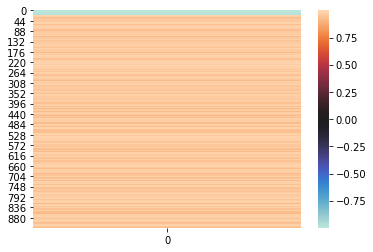

metacluster_0
activity pattern: [1]
metacluster_0 pattern_0
total seqlets: 181
Hypothetical scores:


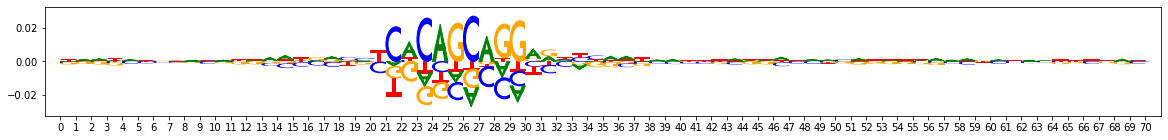

Actual importance scores:


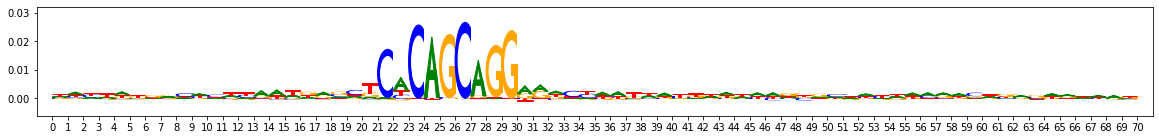

onehot, fwd and rev:


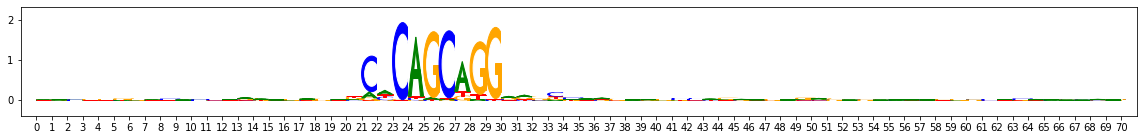

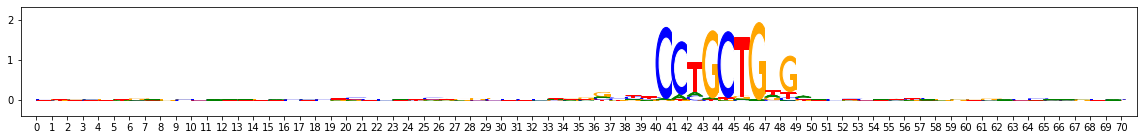

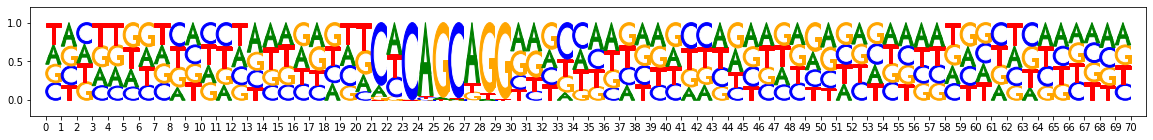

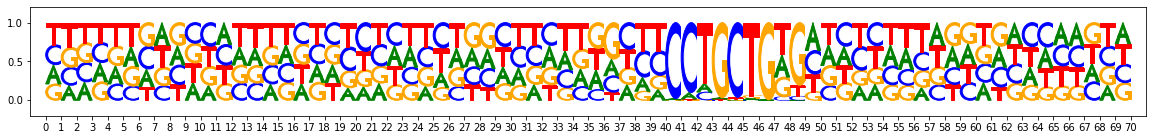

metacluster_0 pattern_1
total seqlets: 161
Hypothetical scores:


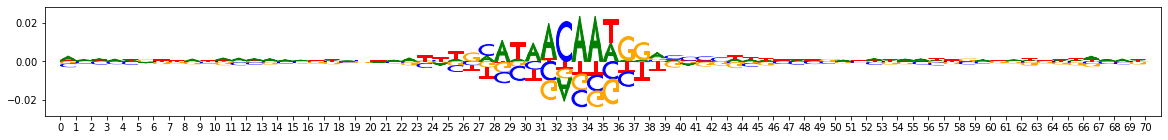

Actual importance scores:


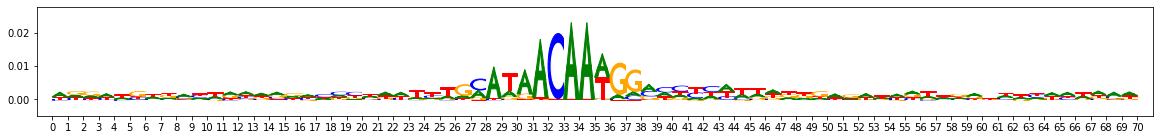

onehot, fwd and rev:


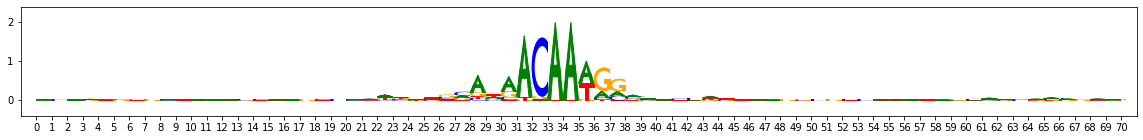

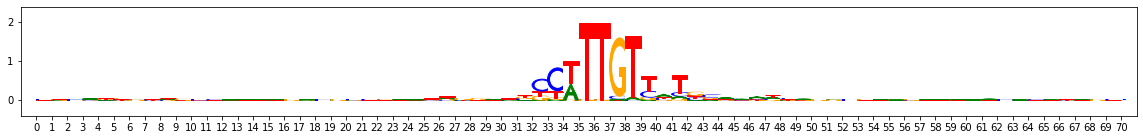

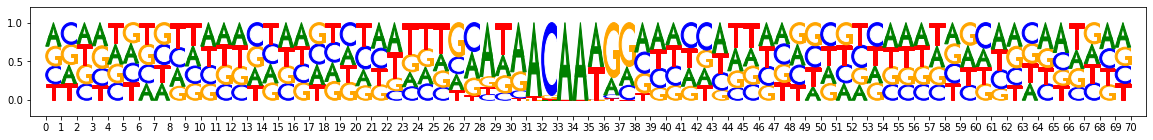

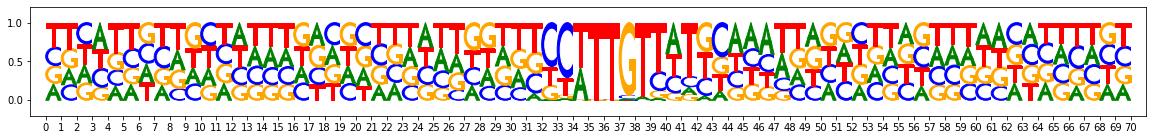

metacluster_0 pattern_2
total seqlets: 50
Hypothetical scores:


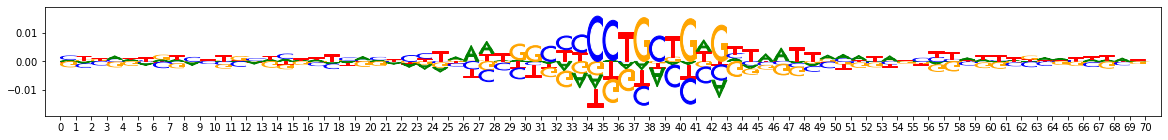

Actual importance scores:


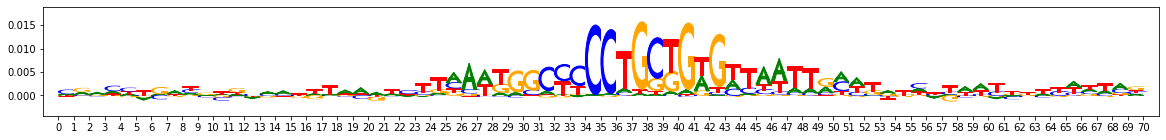

onehot, fwd and rev:


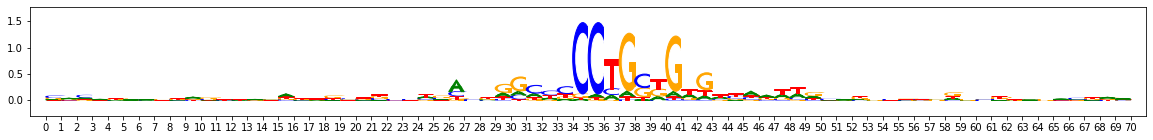

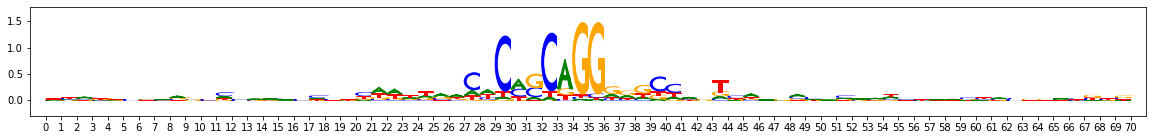

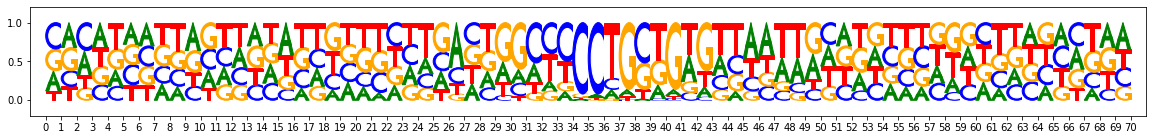

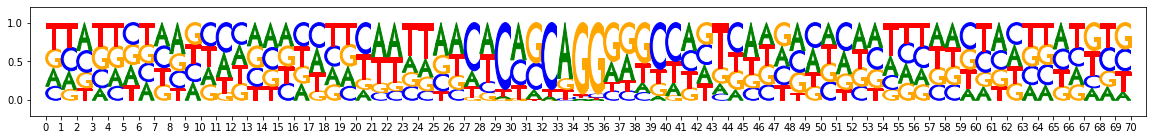

metacluster_0 pattern_3
total seqlets: 50
Hypothetical scores:


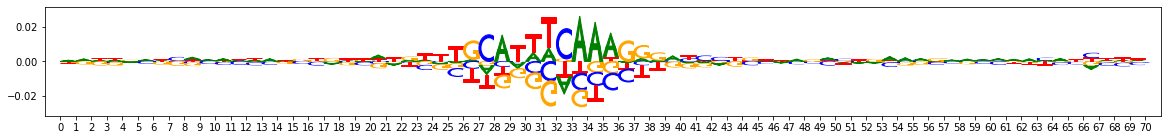

Actual importance scores:


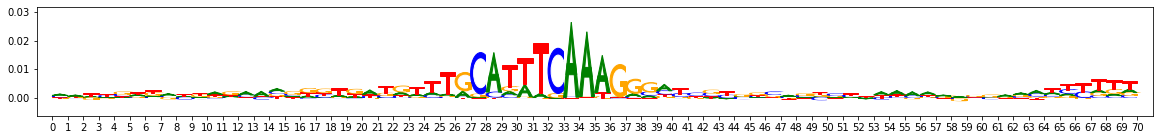

onehot, fwd and rev:


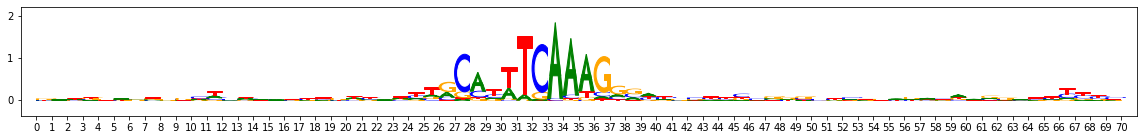

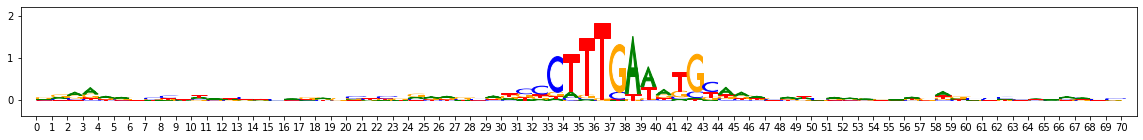

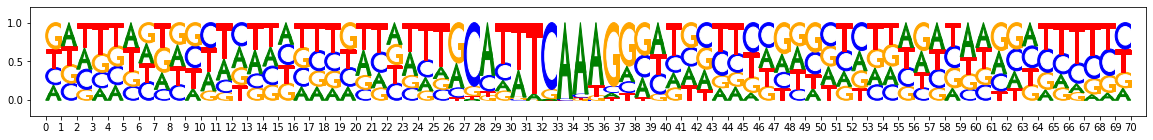

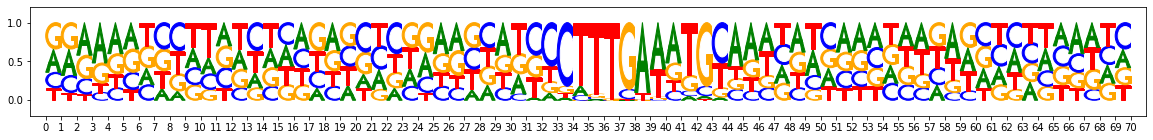

metacluster_0 pattern_4
total seqlets: 48
Hypothetical scores:


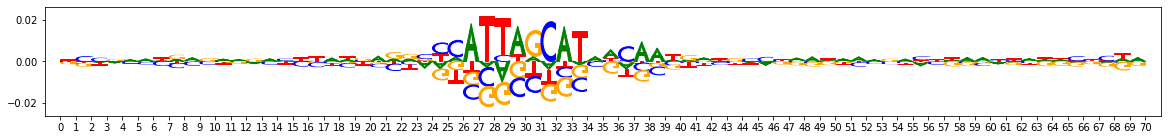

Actual importance scores:


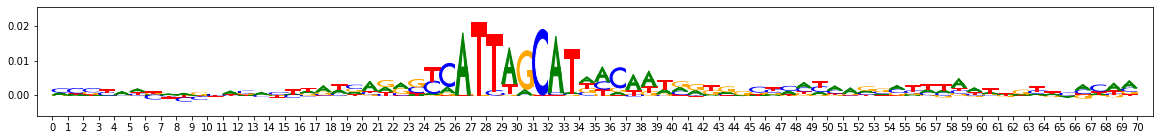

onehot, fwd and rev:


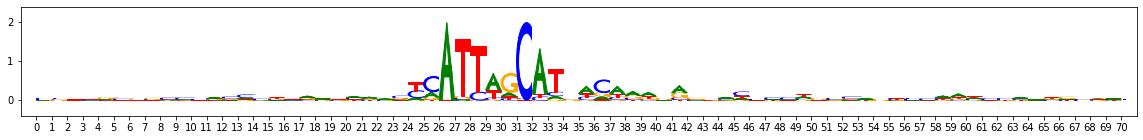

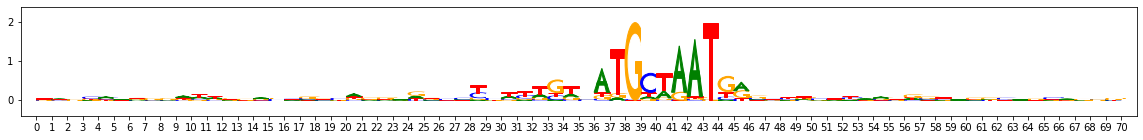

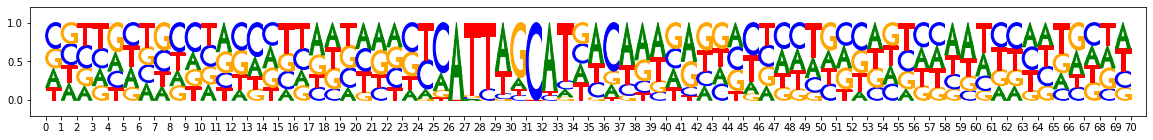

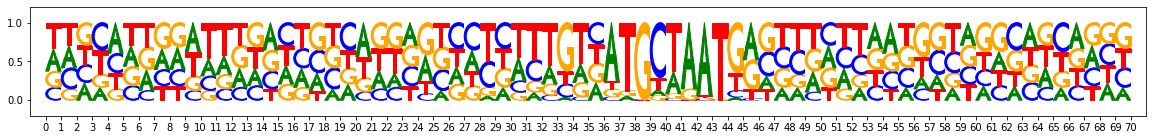

metacluster_0 pattern_5
total seqlets: 49
Hypothetical scores:


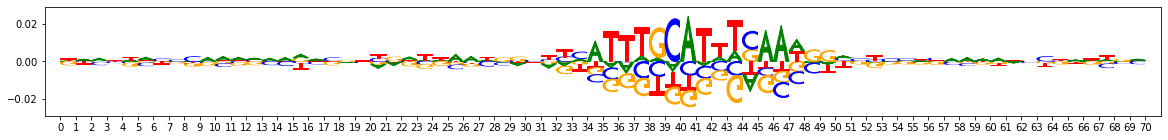

Actual importance scores:


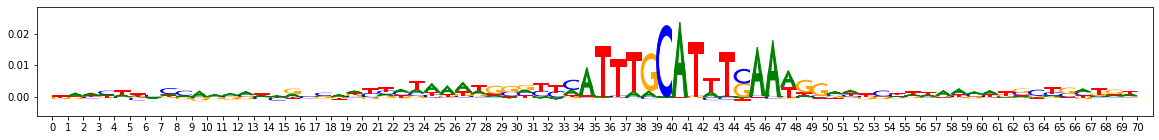

onehot, fwd and rev:


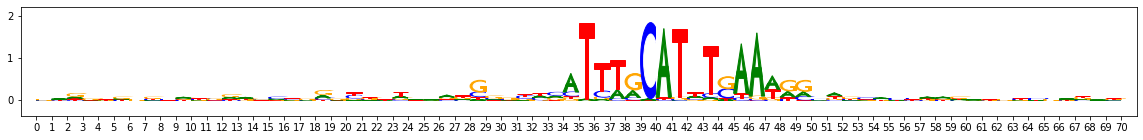

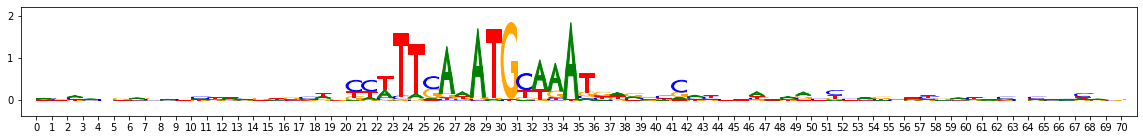

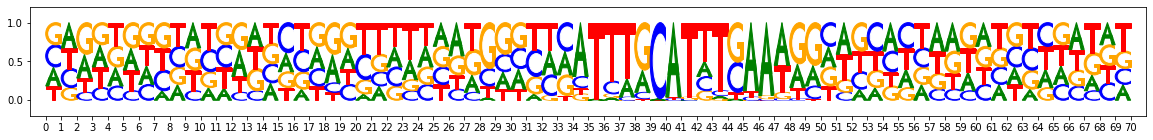

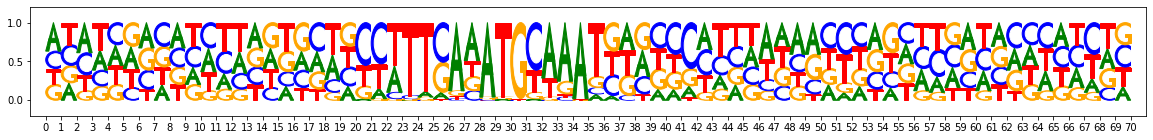

metacluster_0 pattern_6
total seqlets: 42
Hypothetical scores:


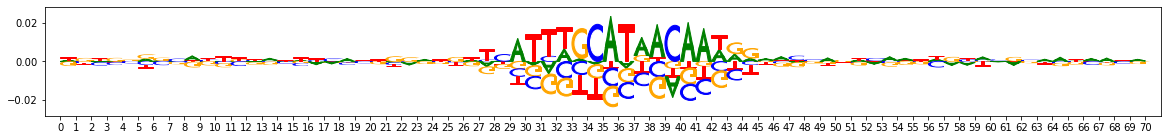

Actual importance scores:


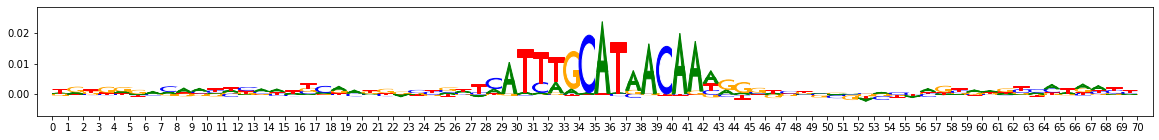

onehot, fwd and rev:


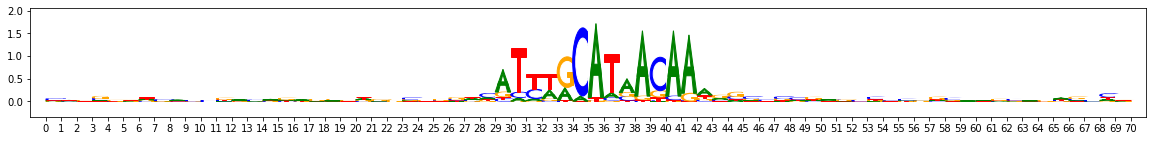

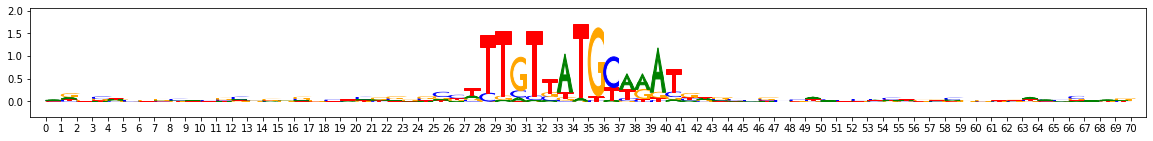

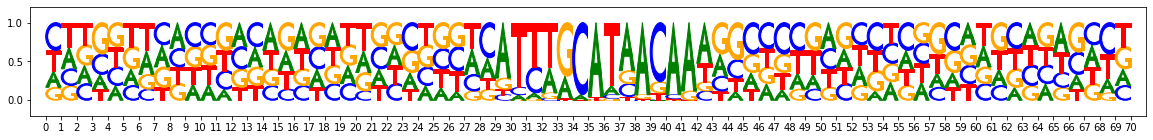

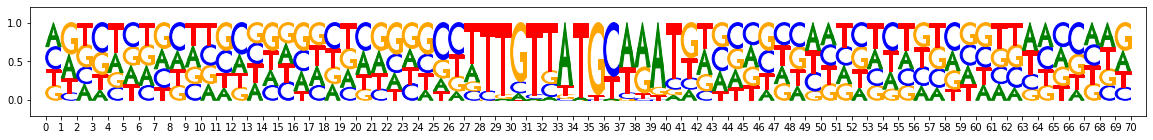

metacluster_0 pattern_7
total seqlets: 30
Hypothetical scores:


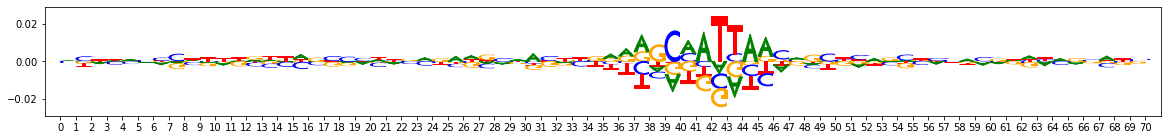

Actual importance scores:


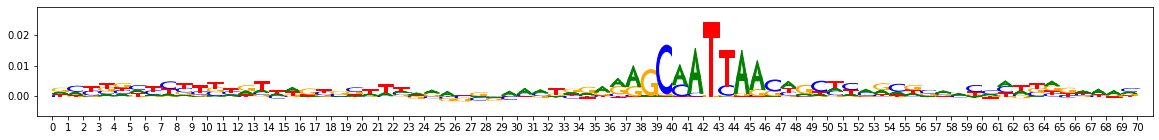

onehot, fwd and rev:


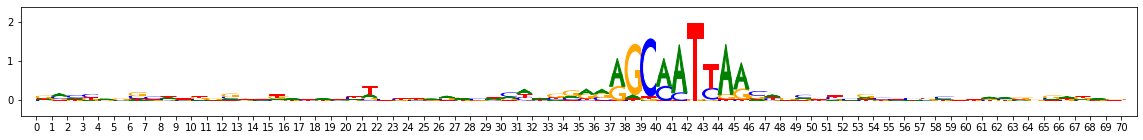

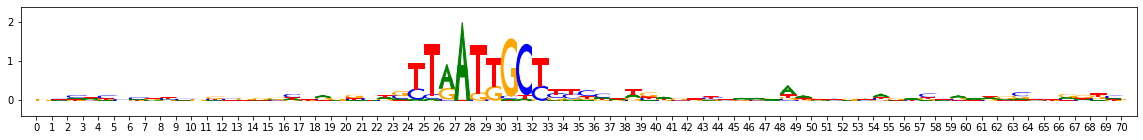

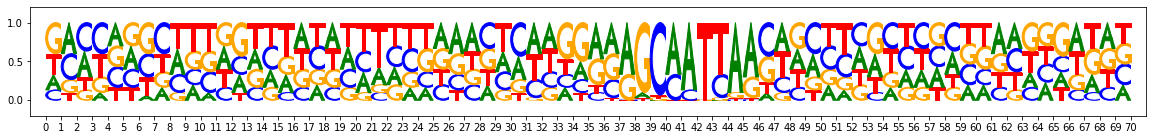

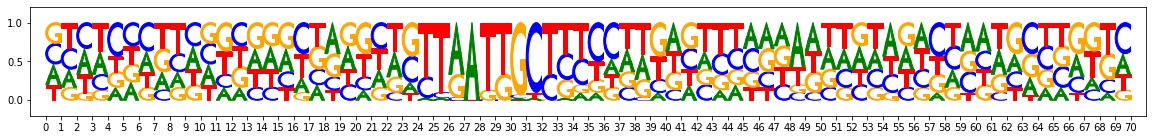

In [14]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5", "r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background))
        viz_sequence.plot_weights(pattern["sequence"]["fwd"]) 
        viz_sequence.plot_weights(pattern["sequence"]["rev"]) 
        
        ##Plot the subclustering too, if available
        #if ("subclusters" in pattern):
        #    print("PLOTTING SUBCLUSTERS")
        #    subclusters = np.array(pattern["subclusters"])
        #    twod_embedding = np.array(pattern["twod_embedding"])
        #    plt.scatter(twod_embedding[:,0], twod_embedding[:,1], c=subclusters, cmap="tab20")
        #    plt.show()
        #    for subcluster_name in list(pattern["subcluster_to_subpattern"]["subcluster_names"]):
        #        subpattern = pattern["subcluster_to_subpattern"][subcluster_name]
        #        print(subcluster_name.decode("utf-8"), "size", len(subpattern["seqlets_and_alnmts"]["seqlets"]))
        #        subcluster = int(subcluster_name.decode("utf-8").split("_")[1])
        #        plt.scatter(twod_embedding[:,0], twod_embedding[:,1], c=(subclusters==subcluster))
        #        plt.show()
        #        viz_sequence.plot_weights(subpattern["task0_hypothetical_contribs"]["fwd"])
        #        viz_sequence.plot_weights(subpattern["task0_contrib_scores"]["fwd"])
        #        viz_sequence.plot_weights(subpattern["sequence"]["fwd"])
        
hdf5_results.close()